In [34]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models
from torchvision.datasets import ImageNet

import torch.autograd as autograd

from matplotlib import pyplot as plt

#delete
import numpy as np
from scipy.sparse.linalg import LinearOperator

In [2]:
class ModelFeatureExtracter(nn.Module):
    def __init__(self, model, layer):
        super().__init__()
        self.model = model
        self.layer = layer
        self.model.eval()
        
    def extract_layer_output(self, x):
        outputs = []
        def extracting_hook(module, input, output):
            outputs.append(output)
        
        hook_handle = self.layer.register_forward_hook(extracting_hook)
        
        self.model(x)
        
        hook_handle.remove()
        return outputs[-1]
    
    def forward(self, x):
        with torch.no_grad():
            return self.model(x)

In [21]:
class JacobianOperator:
    def __init__(self, img_batch, model_feature_extractor, input_dim, hidden_dim):
        self.img_batch = img_batch
        self.mfe = model_feature_extractor
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
    def _matvec_grad(self, img, vec):
        w = torch.zeros(self.hidden_dim, requires_grad=True)
        matvec_transposed = self._matvec_T_grad(img, w)
        dotproduct = torch.matmul(matvec_transposed.flatten(), vec.flatten())
        return autograd.grad(dotproduct, w)[0]

    def _matvec_T_grad(self, img, vec):
        img.requires_grad = True
        layer_output = self.mfe.extract_layer_output(img)
        dotproduct = torch.matmul(layer_output.flatten(), vec.flatten())
        return autograd.grad(dotproduct, img, create_graph=True)[0]
    
    def matvec(self, vec):
        output = []
        for img in self.img_batch:
            output.append(self._matvec_grad(img.unsqueeze(0), vec))
        return torch.cat(output)
    
    def matvec_T(self, vec):
        output = torch.zeros(self.input_dim)
        vec_flatten = vec.reshape(-1, self.hidden_dim)
        for img, vec in zip(self.img_batch, vec_flatten):
            output += self._matvec_T_grad(img.unsqueeze(0), vec).flatten()
        return output

In [55]:
def psi(x, p=2):
    return torch.sign(x) * torch.abs(x) ** (p - 1)


def power_method(jac, p=2, q=2, maxiter=20):
    v = torch.rand(jac.input_dim) - 0.5
    v = v / torch.norm(v, p=p)
    p2 = 1.0 / (1.0 - 1.0 / p)
    
    for i in range(maxiter):
        Jv = jac.matvec(v)
        v = psi(jac.matvec_T(psi(Jv, q)), p2)
        v = v / torch.norm(v, p=p)
        
        s = torch.norm(jac.matvec(v), p=q)
        print(i, s)
    s = torch.norm(jac.matvec(v), p=q)
    return v, s

In [67]:
model = torchvision.models.vgg16(pretrained=True)
layer_to_extract_from = model.features[9]
me = ModelFeatureExtracter(model, layer_to_extract_from)

In [68]:
test_x = torch.rand((10, 3, 224, 224))

In [69]:
input_dim = torch.prod(torch.tensor(test_x.shape[1:])).item()
hidden_dim = torch.prod(torch.tensor(me.extract_layer_output(test_x).shape[1:])).item()

In [70]:
jac = JacobianOperator(test_x, me, input_dim, hidden_dim)

In [71]:
v, s = power_method(jac, p=float('inf'), q=10)

0
0 tensor(617.3176)
1
1 tensor(674.7598)
2
2 tensor(695.1417)
3
3 tensor(706.9138)
4
4 tensor(713.9587)
5
5 tensor(719.6979)
6
6 tensor(723.5002)
7
7 tensor(726.5179)
8
8 tensor(729.3689)
9
9 tensor(731.8806)
10
10 tensor(733.6642)
11
11 tensor(735.2002)
12
12 tensor(736.2130)
13
13 tensor(737.3615)
14
14 tensor(738.3599)
15
15 tensor(739.1160)
16
16 tensor(739.9964)
17
17 tensor(740.6457)
18
18 tensor(740.9561)
19
19 tensor(741.3491)


In [72]:
v.max()

tensor(1., grad_fn=<MaxBackward1>)

In [73]:
torch.tensor(test_x.shape[1:])

tensor([  3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


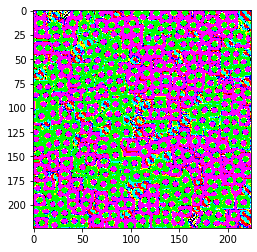

In [81]:
tt = v / torch.norm(v, p=float('inf'))
pic = tt.reshape(list(test_x.shape[1:])).detach().permute(1, 2, 0).numpy()
plt.imshow(10 * pic)

In [3]:
# def matvec_transposed(inp, model, vector):
#     inp.requires_grad = True
#     layer_output = model.extract_layer_output(inp)
#     dotproduct = torch.matmul(layer_output.flatten(), vector.flatten())
#     return autograd.grad(dotproduct, inp, create_graph=True)[0]


# def matvec(inp, model, vector, hidden_dim):
#     w = torch.zeros(hidden_dim, requires_grad=True)
#     matvec_transposed = get_matvec_transposed(inp, model, w)
#     dotproduct = torch.matmul(matvec_transposed.flatten(), vector.flatten())
#     return autograd.grad(dotproduct, w)[0]

In [ ]:
me.extract_layer_output(test_x).shape

In [ ]:
tr_vector = torch.rand((1, hidden_dim))
vector = torch.rand((1, input_dim))

In [ ]:
mv_tr = get_matvec_transposed(test_x, me, tr_vector)

In [ ]:
mv_tr.shape

In [ ]:
mv = get_matvec(test_x, me, vector, hidden_dim)

In [ ]:
mv.shape